In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import torch as th
from torch.autograd import Variable as V
import torch.autograd as autograd
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset, random_split
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
import torch.nn.functional as F
import torch.optim as optim
from numpy import vstack
%matplotlib inline
from sklearn.metrics import confusion_matrix,classification_report
from sklearn.utils import shuffle
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import MinMaxScaler
import pickle
import os
import timeit
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score
from sklearn.metrics import accuracy_score

In [331]:
# # GAN - Discriminator
# class Discriminator(nn.Module):
#     def __init__(self,input_dim):
#         super(Discriminator, self).__init__()
#         self.layer = nn.Sequential(
#             nn.Linear(input_dim, input_dim*2),
#             nn.ReLU(True),
#             nn.Linear(input_dim*2,1),
#             nn.Sigmoid()
            

#         )
#     def forward(self,x):
#         return self.layer(x)   

In [327]:
# class Generator(nn.Module):
#     def __init__(self,input_dim):
#         super(Generator, self).__init__()
#         self.layer = nn.Sequential(
#             nn.Linear(input_dim, input_dim//2),
#             nn.ReLU(True),
#             nn.Linear(input_dim//2, input_dim//2),
#             nn.ReLU(True),
#             nn.Linear(input_dim//2, input_dim),
#             nn.LeakyReLU(True)
# #             nn.Linear(input_dim, input_dim//2),
# #             nn.LeakyReLU(True),
# #             nn.Linear(input_dim//2, input_dim),
# #             nn.LeakyReLU()
             
           
   
#         )
#     def forward(self, z):
#          return self.layer(z)

In [120]:
class Generator(nn.Module):
    def __init__(self,input_dim):
        super(Generator, self).__init__()
        self.layer = nn.Sequential(
            nn.Linear(input_dim, input_dim//2),
            nn.LeakyReLU(True),
            nn.Linear(input_dim//2, input_dim),
            nn.Sigmoid()
   
        )
    def forward(self, z):
         return self.layer(z)
        
        
def gen_adversarial_attack(generator_out, raw_attack, attack_category,POS_NONFUNCTIONAL_FEATURES):
    pos_nonfunctional_feature = POS_NONFUNCTIONAL_FEATURES[attack_category]
    # Keep the functional features
    adversarial_attack = raw_attack.clone().type(th.FloatTensor)
#     adversarial_attack = raw_attack.detach()
    for row_idx in range(len(adversarial_attack)):
        adversarial_attack[row_idx][pos_nonfunctional_feature] = generator_out[row_idx]
    return adversarial_attack

In [121]:
# GAN - Discriminator
class Discriminator(nn.Module):
    def __init__(self,input_dim):
        super(Discriminator, self).__init__()
        self.layer = nn.Sequential(
            nn.Linear(input_dim, input_dim*2),
            nn.LeakyReLU(True),
            nn.Linear(input_dim*2,1),
            nn.Sigmoid()

        )
    def forward(self,x):
        return self.layer(x) 

In [4]:
data = pd.read_csv('..\WGAN_2021\GAN_train_2.csv')

In [5]:
attack_data = data[data['Label'] == 1]
attack_labels = data[data['Label'] == 1]['Label']
attack_data = attack_data.drop('Label',axis=1)
# Convert  to torch tensor.
attack_data = th.from_numpy(attack_data.to_numpy()).type(th.float)
attack_labels = th.from_numpy(attack_labels.to_numpy()).type(th.float)
# Create a tensor dataset
attack_ds = TensorDataset(attack_data,attack_labels)


In [122]:
batch = 512
num_epochs = 100
N_FEATURES = 41
input_length = N_FEATURES


In [100]:
FUN_FEATURES = [0, 1, 2, 3, 4, 5, 6, 7, 8, 23, 24, 25, 26, 27, 28, 29, 30]

POS_FUNCTIONAL_FEATURES = {'DDoS': FUN_FEATURES}
POS_NONFUNCTIONAL_FEATURES = {}
for attack_category, pos_functional_feature in POS_FUNCTIONAL_FEATURES.items():
    pos_nonfunctional_feature = []
    for i in range(N_FEATURES):
        if i not in pos_functional_feature:
            pos_nonfunctional_feature.append(i)
    POS_NONFUNCTIONAL_FEATURES[attack_category] = pos_nonfunctional_feature

In [74]:
G_INPUT_DIM = len(POS_NONFUNCTIONAL_FEATURES[attack_category])

In [9]:
print(G_INPUT_DIM)

24


In [10]:
print('Position of Functional Features\n  ', POS_FUNCTIONAL_FEATURES)
print('Position of Non Functional Features:\n  ', POS_NONFUNCTIONAL_FEATURES)

Position of Functional Features
   {'DDoS': [0, 1, 2, 3, 4, 5, 6, 7, 8, 23, 24, 25, 26, 27, 28, 29, 30]}
Position of Non Functional Features:
   {'DDoS': [9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40]}


In [123]:
generator = Generator(G_INPUT_DIM)
discriminator = Discriminator(input_length)
generator_optimizer = th.optim.Adam(generator.parameters(), lr=0.002)
discriminator_optimizer = th.optim.Adam(discriminator.parameters(), lr=0.002)

In [124]:
def train():
     # Models
    generator.train()
    discriminator.train()

    # loss
    loss = nn.BCELoss()
    g_loss_vals = []
    d_loss_vals = []
    adversarial_dr_vals = []
    for i in range(num_epochs):

#          # zero the gradients on each iteration
#         generator_optimizer.zero_grad()
        for p in discriminator.parameters():  
            p.requires_grad = False
         # zero the gradients on each iteration
        generator_optimizer.zero_grad()

        attack_dl = DataLoader(attack_ds, batch_size=batch,shuffle = True)
        attack_data,attack_label = iter(attack_dl).next()
   
         
        noise = th.randint(0, 2, size=(len(attack_label), G_INPUT_DIM)).float()
        length = len(attack_data)

        pos_nonfunctional_feature = POS_NONFUNCTIONAL_FEATURES['DDoS']
        nonfunctional_feature = attack_data[:, pos_nonfunctional_feature]
        
        attack_traffic = th.cat((noise,nonfunctional_feature),dim = 0)
        l = list(range(length))
        np.random.shuffle(l)
        attack_traffic = attack_traffic[l]
        generator_out = generator(attack_traffic)
       
        fake_attack_data = gen_adversarial_attack(generator_out, attack_data, attack_category, POS_NONFUNCTIONAL_FEATURES)
        
        
        pred_ids = ids_model.predict(fake_attack_data.detach())
        pred_normal = len(pred_ids[pred_ids==0])
        pred_attack = len(pred_ids[pred_ids==1])
        
        print('Attack',pred_attack)
#         print('Normal',pred_normal)

              
        attack_label = attack_label.reshape(len(attack_label),1)      
        generator_discriminator_out = discriminator(fake_attack_data)
        
#         print(accuracy_score(attack_label,ids_model.predict(generated_data.detach())))
        
        generator_loss = loss(generator_discriminator_out, attack_label)
        g_loss_vals.append(generator_loss)
        generator_loss.backward()
        generator_optimizer.step()
        
#         # Train the discriminator on the true/generated data
        
        # Train Discreminator
        for p in discriminator.parameters(): 
            p.requires_grad = True    
        discriminator_optimizer.zero_grad()
        
        true_discriminator_out = discriminator(attack_data)
       
        true_discriminator_loss = loss(true_discriminator_out, attack_label)
        
        
        generator_discriminator_out = discriminator(fake_attack_data.detach())
        fake_data = th.ones(len(attack_label))
       
        fake_data = fake_data.reshape(len(attack_label),1)
#         attack_label = attack_label.reshape(len(attack_label),1)
        generator_discriminator_loss = loss(generator_discriminator_out, fake_data)
        
        discriminator_loss = (true_discriminator_loss + generator_discriminator_loss) / 2
        d_loss_vals.append(discriminator_loss.item())
        discriminator_loss.backward()
        discriminator_optimizer.step()
     
    return g_loss_vals, d_loss_vals

In [125]:
g,d = train()

Attack 457
Attack 455
Attack 441
Attack 452
Attack 452
Attack 456
Attack 455
Attack 451
Attack 473
Attack 460
Attack 474
Attack 477
Attack 482
Attack 479
Attack 488
Attack 486
Attack 492
Attack 481
Attack 488
Attack 496
Attack 480
Attack 495
Attack 493
Attack 503
Attack 502
Attack 499
Attack 502
Attack 503
Attack 505
Attack 506
Attack 506
Attack 502
Attack 509
Attack 507
Attack 509
Attack 511
Attack 503
Attack 510
Attack 511
Attack 510
Attack 507
Attack 508
Attack 511
Attack 511
Attack 511
Attack 510
Attack 510
Attack 509
Attack 509
Attack 512
Attack 510
Attack 510
Attack 510
Attack 511
Attack 509
Attack 511
Attack 511
Attack 510
Attack 509
Attack 511
Attack 511
Attack 512
Attack 511
Attack 512
Attack 512
Attack 512
Attack 511
Attack 510
Attack 511
Attack 509
Attack 511
Attack 510
Attack 512
Attack 509
Attack 511
Attack 511
Attack 510
Attack 512
Attack 510
Attack 511
Attack 511
Attack 510
Attack 510
Attack 511
Attack 511
Attack 511
Attack 512
Attack 510
Attack 512
Attack 510
Attack 512

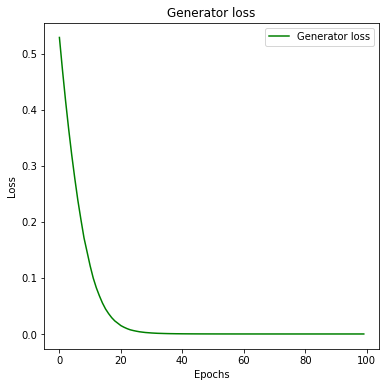

In [127]:
epochs = np.linspace(0, num_epochs-1, num_epochs).astype(int)
plt.figure(figsize=(6,6))
plt.plot(epochs, g,color = 'g',label = 'Generator loss')
# Naming the x-axis, y-axis and the whole graph
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Generator loss")
# Adding legend, which helps us recognize the curve according to it's color
plt.legend()

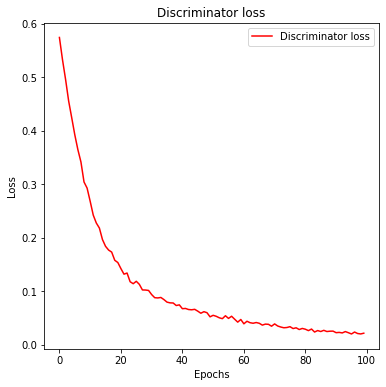

In [129]:
epochs = np.linspace(0, num_epochs-1, num_epochs).astype(int)
plt.figure(figsize=(6,6))
plt.plot(epochs, d,color = 'r',label = 'Discriminator loss')
# Naming the x-axis, y-axis and the whole graph
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Discriminator loss")
# Adding legend, which helps us recognize the curve according to it's color
plt.legend()

In [12]:
# load the model from disk
def load_model(filename):
 loaded_model = pickle.load(open(filename, 'rb'))
 return loaded_model

In [13]:
ids_name = '..\WGAN_2021\ids_model_2.sav'

In [14]:
# Load Trained IDS Model
ids_model = load_model(ids_name)

In [431]:
test_path = "..\WGAN_2021\GAN_test_2.csv"

In [432]:
test_data = pd.read_csv(test_path)

In [433]:
test_attack_data = test_data[test_data['Label'] == 1]
test_attack_labels = test_data[test_data['Label'] == 1]['Label']
test_attack_data = test_data.drop('Label',axis=1)
# Convert  to torch tensor.
test_attack_data = th.from_numpy(test_attack_data.to_numpy()).type(th.float)
test_attack_labels = th.from_numpy(test_attack_labels.to_numpy()).type(th.float)
# Create a tensor dataset
# attack_ds = TensorDataset(attack_data,attack_labels)

In [434]:
# noise = th.randint(0, 2, size=(len(attack_labels), input_length)).float()    
# length = len(attack_data)
        
generated_data = generator(test_attack_data)

In [435]:
generated_data.shape

torch.Size([104712, 41])

In [436]:
d = ids_model.predict(generated_data.detach())

In [437]:
d

array([0., 0., 0., ..., 0., 0., 0.])